I was working on an online retail dataset when I noticed that many customers had not been active for at least six months. A large portion of them had made only one purchase and never returned.
I realized that if I could identify customers who were likely to purchase again within the next three months, it would be valuable for the marketing team. They could then approach these customers with personalized promotions and targeted retention strategies

My task was to build a predictive model that could classify whether a customer will make a purchase within the next 3 months after their latest transaction. The goal was to help the business focus marketing efforts on high-potential customers.

I took the following steps:

    Data Preprocessing: Cleaned the transactional dataset (removed returns, handled missing CustomerIDs, etc.).

    Feature Engineering: Created customer-level features like:

    Recency (days since last purchase)

    Frequency (number of purchases)

    Monetary (total spend)

    Average basket size

    Time gap between purchases

    Month of last purchase

    Target Variable: For each customer, I marked the target as 1 if they made any purchase in the next 3 months, else 0.

    Modeling: Trained and tested multiple classifiers — Logistic Regression, Random Forest, and XGBoost.

    Evaluation: Chose the best model based on metrics like AUC-ROC, precision, and recall, since class imbalance was present.

I trained and tested the model using historical transaction data, simulating future purchases through a time-based holdout.
The final model achieved an AUC-ROC of 0.96, with 91% precision and 99% recall on the test set.
It accurately identified customers likely to return within 3 months while minimizing false positives.
The output can help the marketing team strategically approach those high-potential customers through targeted promotions or campaigns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('og.csv')

In [3]:
pd.set_option('display.max_columns', None)
df = df.drop(columns = 'Unnamed: 0')

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,invoice_mnth,invoicedayweek,Total_revenue,InvoiceIdentity,Year,Quantity_group,UniPrice_group,TotalRevenue_group,invoice_month_name,classify_customer,Country_Segment,invoice_month,cohort_month,cohort_index
0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313.0,United Kingdom,1,Tuesday,19.5,Normal_Product,2011,5–10,1–5,10–50,Jan,Loyal and High Value,United Kingdom - Loyal and High Value,2011-01,2011-01,0
1,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,1,Tuesday,10.5,Normal_Product,2011,10–50,≤1,10–50,Jan,Loyal and High Value,United Kingdom - Loyal and High Value,2011-01,2011-01,0
2,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,1,Tuesday,10.5,Normal_Product,2011,10–50,≤1,10–50,Jan,Loyal and High Value,United Kingdom - Loyal and High Value,2011-01,2011-01,0
3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313.0,United Kingdom,1,Tuesday,10.5,Normal_Product,2011,1–5,1–5,10–50,Jan,Loyal and High Value,United Kingdom - Loyal and High Value,2011-01,2011-01,0
4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313.0,United Kingdom,1,Tuesday,12.5,Normal_Product,2011,5–10,1–5,10–50,Jan,Loyal and High Value,United Kingdom - Loyal and High Value,2011-01,2011-01,0


In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [6]:
df['purchase_date'] = df['InvoiceDate'].dt.date

In [7]:
q1 = ['Jan', 'Feb', 'Mar']
q2 = ['Apr', 'May', 'Jun']
q3 = ['Jul', 'Aug', 'Sep']
q4 = ['Oct', 'Nov', 'Dec']

In [8]:
qt1 = df[df['invoice_month_name'].isin(q1)]
qt2 = df[df['invoice_month_name'].isin(q2)]
qt3 = df[df['invoice_month_name'].isin(q3)]
qt4 = df[df['invoice_month_name'].isin(q4)]

In [9]:
def summary(q_df):
    q1_summary = q_df.groupby('CustomerID').agg({'Description':'nunique', 'Total_revenue':'sum', 'UnitPrice':['mean', 'std'], 'InvoiceNo':'nunique',
                                            'purchase_date':['min','max'], 'Quantity':'sum'
                                  }).reset_index()
    
    q1_summary.columns = ['CustomerID', 'no.of_products', 'monetary','unitprice_mean', 'unitprice_std','no.of_transcation', 'purchase_date_min', 'purchase_date_max', 'tot_qn']
    
    q1_summary['purchase_date_max'] = pd.to_datetime(q1_summary['purchase_date_max'])
    q1_summary['purchase_date_min'] = pd.to_datetime(q1_summary['purchase_date_min'])
    q1_summary['day_diff'] = q1_summary['purchase_date_max'] - q1_summary['purchase_date_min']
    q1_summary['day_diff'] = q1_summary['day_diff'].dt.days
    
    q1_end_date = pd.to_datetime(q_df['purchase_date'].max())
    q1_summary['recency'] = (q1_end_date - q1_summary['purchase_date_max']).dt.days

    jn = q_df[['CustomerID', 'classify_customer']]
    jn.drop_duplicates(subset = 'CustomerID', inplace = True)
    q1_df = pd.merge(q1_summary, jn, on = 'CustomerID', how = 'left')

    qt1_df = q1_df.drop(columns = ['purchase_date_min', 'purchase_date_max'])

    return qt1_df

In [10]:
q1_df = summary(qt1)

In [11]:
q2_df = summary(qt2)
q3_df = summary(qt3)
q4_df = summary(qt4)

In [12]:
q12_df = pd.concat([q1_df, q2_df], ignore_index = True)

In [13]:
q34_df = pd.concat([q3_df, q4_df], ignore_index = True)

In [14]:
final_df = pd.concat([q12_df, q34_df], ignore_index = True)

In [15]:
final_df.shape

(8456, 10)

In [16]:
final_df.head()

,CustomerID,no.of_products,monetary,unitprice_mean,unitprice_std,no.of_transcation,tot_qn,day_diff,recency,classify_customer
0,12347.0,29,475.39,2.523103,2.433827,1,315,0,64,Loyal and High Value
1,12348.0,5,187.44,0.402000,0.250440,1,600,0,65,Low Engagement
2,12350.0,16,294.40,1.581250,0.578756,1,196,0,57,Low Engagement
3,12352.0,24,521.18,4.080385,2.979813,3,186,34,9,Loyal and High Value
4,12356.0,35,1947.62,2.748000,3.018054,1,1198,0,72,Bulk Only


In [17]:
final_df.describe()

,CustomerID,no.of_products,monetary,unitprice_mean,unitprice_std,no.of_transcation,tot_qn,day_diff,recency
count,8456.000000,8456.000000,8456.000000,8456.000000,8279.000000,8456.000000,8456.000000,8456.000000,8456.000000
mean,15268.139782,36.162252,919.202494,3.243580,2.756541,1.997162,546.432947,16.598746,30.432474
std,1722.265807,47.401559,3044.143126,4.931968,3.688409,2.453251,1695.370229,25.048394,23.928771
min,12347.000000,1.000000,0.850000,0.060000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,13789.250000,12.000000,229.027500,2.080000,1.567216,1.000000,120.000000,0.000000,10.000000
50%,15239.500000,24.000000,413.645000,2.763333,2.358122,1.000000,250.000000,0.000000,24.000000
75%,16755.000000,45.000000,841.200000,3.693258,3.147536,2.000000,510.000000,33.250000,48.000000
max,18287.000000,1077.000000,98118.180000,295.000000,130.926433,68.000000,52993.000000,91.000000,91.000000


In [18]:
final_df.head()

,CustomerID,no.of_products,monetary,unitprice_mean,unitprice_std,no.of_transcation,tot_qn,day_diff,recency,classify_customer
0,12347.0,29,475.39,2.523103,2.433827,1,315,0,64,Loyal and High Value
1,12348.0,5,187.44,0.402000,0.250440,1,600,0,65,Low Engagement
2,12350.0,16,294.40,1.581250,0.578756,1,196,0,57,Low Engagement
3,12352.0,24,521.18,4.080385,2.979813,3,186,34,9,Loyal and High Value
4,12356.0,35,1947.62,2.748000,3.018054,1,1198,0,72,Bulk Only


In [19]:
final_df['target'] = final_df.apply(lambda x: 1 if x['day_diff'] > 0 else 0, axis = 1)

In [20]:
final_df.head()

,CustomerID,no.of_products,monetary,unitprice_mean,unitprice_std,no.of_transcation,tot_qn,day_diff,recency,classify_customer,target
0,12347.0,29,475.39,2.523103,2.433827,1,315,0,64,Loyal and High Value,0
1,12348.0,5,187.44,0.402000,0.250440,1,600,0,65,Low Engagement,0
2,12350.0,16,294.40,1.581250,0.578756,1,196,0,57,Low Engagement,0
3,12352.0,24,521.18,4.080385,2.979813,3,186,34,9,Loyal and High Value,1
4,12356.0,35,1947.62,2.748000,3.018054,1,1198,0,72,Bulk Only,0


In [21]:
ml_data = final_df.drop(columns = ['day_diff', 'CustomerID'])

In [22]:
ml_data.head()

,no.of_products,monetary,unitprice_mean,unitprice_std,no.of_transcation,tot_qn,recency,classify_customer,target
0,29,475.39,2.523103,2.433827,1,315,64,Loyal and High Value,0
1,5,187.44,0.402000,0.250440,1,600,65,Low Engagement,0
2,16,294.40,1.581250,0.578756,1,196,57,Low Engagement,0
3,24,521.18,4.080385,2.979813,3,186,9,Loyal and High Value,1
4,35,1947.62,2.748000,3.018054,1,1198,72,Bulk Only,0


In [23]:
ml_data['avg_qn_txn'] = ml_data['tot_qn'] / ml_data['no.of_transcation']
ml_data['revenue_per_qn'] = ml_data['monetary'] / ml_data['tot_qn']

In [24]:
ml_data.head()

,no.of_products,monetary,unitprice_mean,unitprice_std,no.of_transcation,tot_qn,recency,classify_customer,target,avg_qn_txn,revenue_per_qn
0,29,475.39,2.523103,2.433827,1,315,64,Loyal and High Value,0,315.0,1.509175
1,5,187.44,0.402000,0.250440,1,600,65,Low Engagement,0,600.0,0.312400
2,16,294.40,1.581250,0.578756,1,196,57,Low Engagement,0,196.0,1.502041
3,24,521.18,4.080385,2.979813,3,186,9,Loyal and High Value,1,62.0,2.802043
4,35,1947.62,2.748000,3.018054,1,1198,72,Bulk Only,0,1198.0,1.625726


In [25]:
x = ml_data.drop(columns = 'target')
y = ml_data['target']

In [26]:
x.head()

,no.of_products,monetary,unitprice_mean,unitprice_std,no.of_transcation,tot_qn,recency,classify_customer,avg_qn_txn,revenue_per_qn
0,29,475.39,2.523103,2.433827,1,315,64,Loyal and High Value,315.0,1.509175
1,5,187.44,0.402000,0.250440,1,600,65,Low Engagement,600.0,0.312400
2,16,294.40,1.581250,0.578756,1,196,57,Low Engagement,196.0,1.502041
3,24,521.18,4.080385,2.979813,3,186,9,Loyal and High Value,62.0,2.802043
4,35,1947.62,2.748000,3.018054,1,1198,72,Bulk Only,1198.0,1.625726


In [27]:
x.select_dtypes(include=['int64', 'float64']).corr()

,no.of_products,monetary,unitprice_mean,unitprice_std,no.of_transcation,tot_qn,recency,avg_qn_txn,revenue_per_qn
no.of_products,1.000000,0.397189,-0.060932,-0.005819,0.638935,0.431308,-0.211938,0.216657,-0.060104
monetary,0.397189,1.000000,-0.010342,0.001611,0.528775,0.910965,-0.138947,0.442562,-0.007491
unitprice_mean,-0.060932,-0.010342,1.000000,0.503863,-0.018124,-0.041467,0.036823,-0.094682,0.949663
unitprice_std,-0.005819,0.001611,0.503863,1.000000,0.000338,-0.022400,0.023896,-0.057122,0.215198
no.of_transcation,0.638935,0.528775,-0.018124,0.000338,1.000000,0.545367,-0.295275,0.061071,-0.017351
tot_qn,0.431308,0.910965,-0.041467,-0.022400,0.545367,1.000000,-0.143125,0.543713,-0.036829
recency,-0.211938,-0.138947,0.036823,0.023896,-0.295275,-0.143125,1.000000,-0.015243,0.034258
avg_qn_txn,0.216657,0.442562,-0.094682,-0.057122,0.061071,0.543713,-0.015243,1.000000,-0.088222
revenue_per_qn,-0.060104,-0.007491,0.949663,0.215198,-0.017351,-0.036829,0.034258,-0.088222,1.000000


In [28]:
ml_data.select_dtypes(include=['int64', 'float64']).corr()['target'].sort_values(ascending=False)

target               1.000000
no.of_transcation    0.494827
no.of_products       0.331019
tot_qn               0.219947
monetary             0.211500
avg_qn_txn           0.004892
unitprice_std        0.003596
unitprice_mean      -0.014804
revenue_per_qn      -0.018024
recency             -0.427077
Name: target, dtype: float64

In [29]:
cat_col = x.select_dtypes(include = 'object').columns
num_col = x.select_dtypes(exclude = 'object').columns

In [30]:
cat_col

Index(['classify_customer'], dtype='object')

In [31]:
num_col

Index(['no.of_products', 'monetary', 'unitprice_mean', 'unitprice_std',
       'no.of_transcation', 'tot_qn', 'recency', 'avg_qn_txn',
       'revenue_per_qn'],
      dtype='object')

In [32]:
ml_data.isna().sum()

no.of_products         0
monetary               0
unitprice_mean         0
unitprice_std        177
no.of_transcation      0
tot_qn                 0
recency                0
classify_customer      0
target                 0
avg_qn_txn             0
revenue_per_qn         0
dtype: int64

In [33]:
ml_data['unitprice_std'] = ml_data['unitprice_std'].fillna(0)

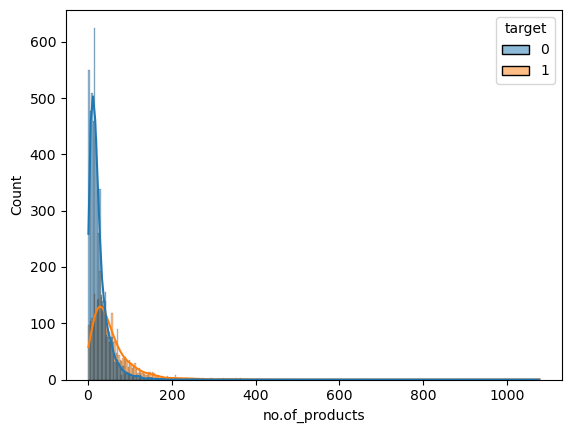

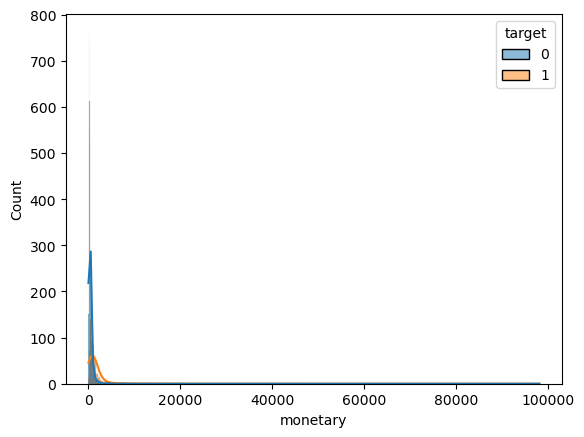

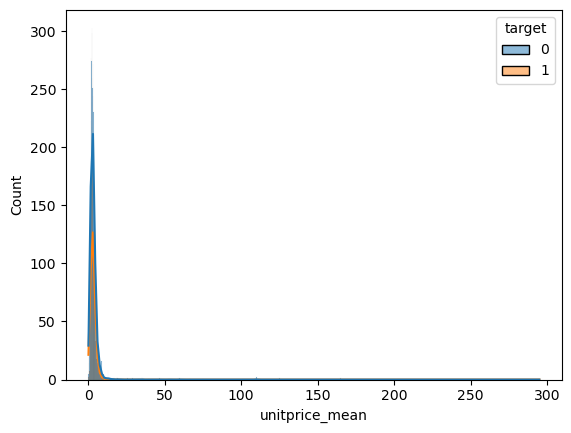

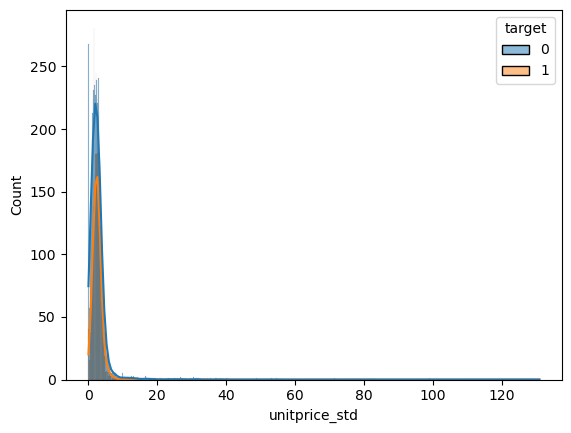

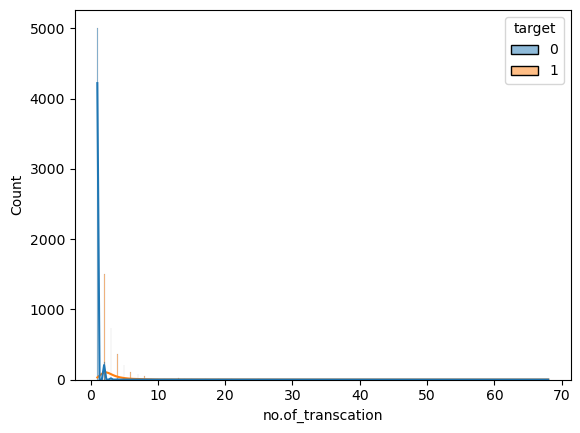

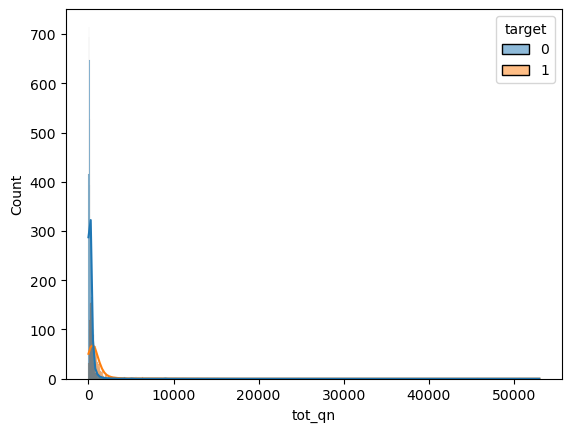

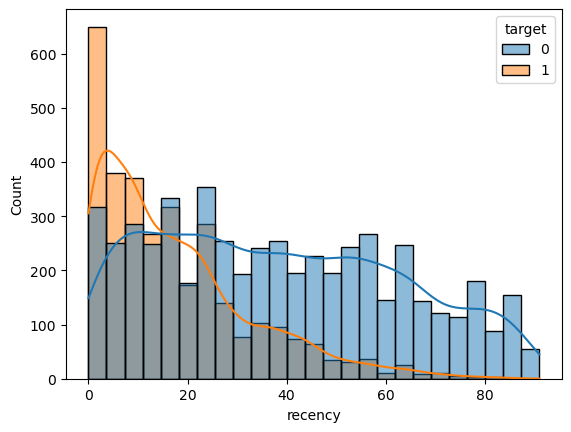

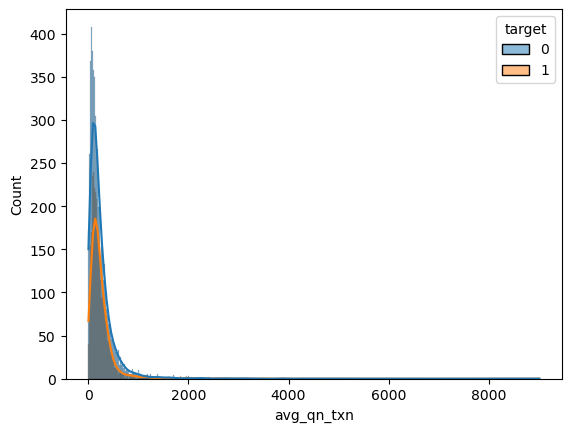

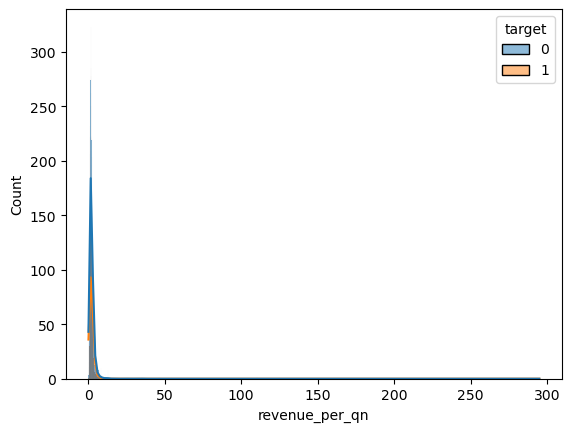

In [34]:
for col in num_col:
    sns.histplot(data = ml_data, x = col, kde = True, hue='target')
    plt.show()

<Axes: xlabel='classify_customer', ylabel='count'>

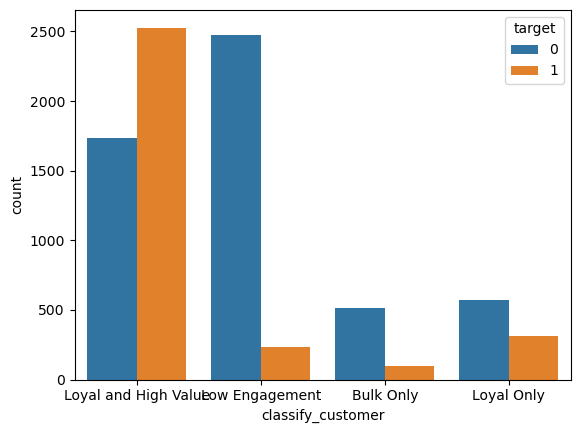

In [35]:
sns.countplot(data = ml_data, x = 'classify_customer', hue = 'target')

In [36]:
ml_data.describe()

,no.of_products,monetary,unitprice_mean,unitprice_std,no.of_transcation,tot_qn,recency,target,avg_qn_txn,revenue_per_qn
count,8456.000000,8456.000000,8456.000000,8456.000000,8456.000000,8456.000000,8456.000000,8456.000000,8456.000000,8456.000000
mean,36.162252,919.202494,3.243580,2.698841,1.997162,546.432947,30.432474,0.374527,247.563105,2.213123
std,47.401559,3044.143126,4.931968,3.670873,2.453251,1695.370229,23.928771,0.484029,347.183749,4.646992
min,1.000000,0.850000,0.060000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000
25%,12.000000,229.027500,2.080000,1.514352,1.000000,120.000000,10.000000,0.000000,93.187500,1.374583
50%,24.000000,413.645000,2.763333,2.325640,1.000000,250.000000,24.000000,0.000000,166.500000,1.793578
75%,45.000000,841.200000,3.693258,3.127779,2.000000,510.000000,48.000000,1.000000,291.375000,2.378089
max,1077.000000,98118.180000,295.000000,130.926433,68.000000,52993.000000,91.000000,1.000000,9014.000000,295.000000


In [37]:
ml_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8456 entries, 0 to 8455
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   no.of_products     8456 non-null   int64  
 1   monetary           8456 non-null   float64
 2   unitprice_mean     8456 non-null   float64
 3   unitprice_std      8456 non-null   float64
 4   no.of_transcation  8456 non-null   int64  
 5   tot_qn             8456 non-null   int64  
 6   recency            8456 non-null   int64  
 7   classify_customer  8456 non-null   object 
 8   target             8456 non-null   int64  
 9   avg_qn_txn         8456 non-null   float64
 10  revenue_per_qn     8456 non-null   float64
dtypes: float64(5), int64(5), object(1)
memory usage: 726.8+ KB


In [38]:
ml_data.isna().sum()

no.of_products       0
monetary             0
unitprice_mean       0
unitprice_std        0
no.of_transcation    0
tot_qn               0
recency              0
classify_customer    0
target               0
avg_qn_txn           0
revenue_per_qn       0
dtype: int64

In [39]:
from sklearn.preprocessing import LabelEncoder, RobustScaler

In [40]:
x.fillna(0, inplace = True)

In [41]:
x.isna().sum()

no.of_products       0
monetary             0
unitprice_mean       0
unitprice_std        0
no.of_transcation    0
tot_qn               0
recency              0
classify_customer    0
avg_qn_txn           0
revenue_per_qn       0
dtype: int64

In [42]:
x.head()

,no.of_products,monetary,unitprice_mean,unitprice_std,no.of_transcation,tot_qn,recency,classify_customer,avg_qn_txn,revenue_per_qn
0,29,475.39,2.523103,2.433827,1,315,64,Loyal and High Value,315.0,1.509175
1,5,187.44,0.402000,0.250440,1,600,65,Low Engagement,600.0,0.312400
2,16,294.40,1.581250,0.578756,1,196,57,Low Engagement,196.0,1.502041
3,24,521.18,4.080385,2.979813,3,186,9,Loyal and High Value,62.0,2.802043
4,35,1947.62,2.748000,3.018054,1,1198,72,Bulk Only,1198.0,1.625726


In [43]:
x.classify_customer.unique()

array(['Loyal and High Value', 'Low Engagement', 'Bulk Only',
       'Loyal Only'], dtype=object)

In [44]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [45]:
x_test.classify_customer.unique()

array(['Loyal and High Value', 'Low Engagement', 'Bulk Only',
       'Loyal Only'], dtype=object)

In [46]:
import pickle
label_encoders = {}

for col in cat_col:
    le = LabelEncoder()
    x_train[col] = le.fit_transform(x_train[col])
    x_test[col] = le.transform(x_test[col])
    label_encoders[col] = le

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

In [47]:
x_test.head()

,no.of_products,monetary,unitprice_mean,unitprice_std,no.of_transcation,tot_qn,recency,classify_customer,avg_qn_txn,revenue_per_qn
2273,14,2003.96,3.992000,3.268079,6,614,34,3,102.333333,3.263779
4462,4,1722.60,4.950000,0.000000,2,348,86,3,174.000000,4.950000
625,29,326.82,0.956207,1.496936,1,645,80,3,645.000000,0.506698
4478,6,335.52,3.265000,2.675173,1,142,36,1,142.000000,2.362817
828,74,201.48,1.701630,1.581857,1,126,8,3,126.000000,1.599048


In [48]:
num_scalar = {}

for i in num_col:
    r_scalar = RobustScaler()
    x_train[i] = r_scalar.fit_transform( x_train[[i]])
    x_test[i] = r_scalar.transform( x_test[[i]])
    num_scalar[i] = r_scalar

with open('num_scaling.pkl', 'wb') as f:
    pickle.dump(num_scalar, f)

In [49]:
x_train.head()

,no.of_products,monetary,unitprice_mean,unitprice_std,no.of_transcation,tot_qn,recency,classify_customer,avg_qn_txn,revenue_per_qn
4119,0.545455,1.298012,-0.126650,-0.160030,0.0,1.066838,1.530201,0,2.525091,0.031452
8139,-0.242424,-0.098591,0.168502,0.106734,0.0,-0.143959,-0.187919,3,0.141688,0.043566
8347,-0.212121,-0.075381,1.054532,1.337909,0.0,0.233933,0.214765,3,0.885553,-0.700117
1583,-0.515152,-0.502318,1.707519,1.172124,0.0,-0.516710,-0.026846,1,-0.592055,0.419817
1412,3.030303,1.789704,0.147703,0.263727,2.0,1.105398,0.026846,3,0.306992,0.431486


<Axes: xlabel='target', ylabel='count'>

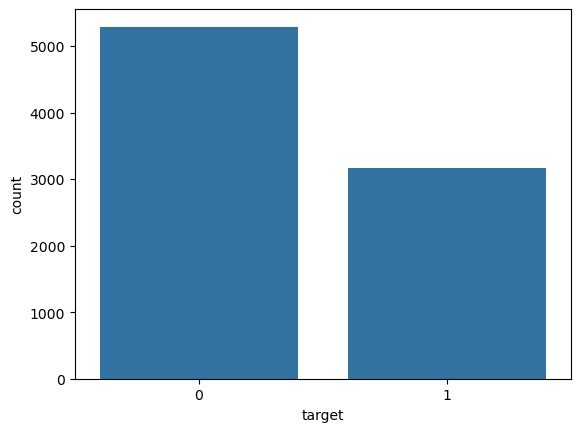

In [50]:
sns.countplot(data = ml_data, x = 'target')

In [51]:
ml_data['target'].value_counts(normalize = True)

target
0    0.625473
1    0.374527
Name: proportion, dtype: float64

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [53]:
x_train.isna().sum()

no.of_products       0
monetary             0
unitprice_mean       0
unitprice_std        0
no.of_transcation    0
tot_qn               0
recency              0
classify_customer    0
avg_qn_txn           0
revenue_per_qn       0
dtype: int64

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [55]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

for name, model in models.items():
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  print(f'{name} Accuracy: {accuracy_score(y_test, y_pred)}')

Logistic Regression Accuracy: 0.9651300236406619
Decision Tree Accuracy: 0.950354609929078
Random Forest Accuracy: 0.9621749408983451
SVM Accuracy: 0.9609929078014184
KNN Accuracy: 0.9533096926713948


In [67]:
rf = RandomForestClassifier(class_weight = 'balanced')
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.960401891252955
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1086
           1       0.91      0.99      0.95       606

    accuracy                           0.96      1692
   macro avg       0.95      0.97      0.96      1692
weighted avg       0.96      0.96      0.96      1692



In [68]:
print(confusion_matrix(y_test, y_pred))

[[1027   59]
 [   8  598]]


In [57]:
from sklearn.ensemble import AdaBoostClassifier

In [58]:
ada_boost = AdaBoostClassifier()
ada_boost.fit(x_train, y_train)
y_pred = ada_boost.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.9627659574468085


In [59]:
with open('predictingdays_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [60]:
def result():
  test_data = {}

  for col in x.columns:
    test_data[col] = input(f'Enter {col}: ')

  test_df = pd.DataFrame([test_data])
  test_df[num_col] = test_df[num_col].astype(float)

  with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

  with open('num_scaling.pkl', 'rb') as f:
    scalar = pickle.load(f)

  for i in cat_col:
    test_df[i] = label_encoder[i].transform(test_df[i])

  for j in num_col:
    test_df[j] = scalar[j].transform(test_df[[j]])

  with open('predictingdays_model.pkl', 'rb') as f:
    model = pickle.load(f)

  pred = model.predict(test_df)
  predict_proba = model.predict_proba(test_df)

  print("Predicted Label:", pred[0])
  print("Prediction Probability:", predict_proba[0])

In [61]:
x.classify_customer.unique()

array(['Loyal and High Value', 'Low Engagement', 'Bulk Only',
       'Loyal Only'], dtype=object)

In [69]:
ml_data[ml_data['target'] == 1].head(1)

,no.of_products,monetary,unitprice_mean,unitprice_std,no.of_transcation,tot_qn,recency,classify_customer,target,avg_qn_txn,revenue_per_qn
3,24,521.18,4.080385,2.979813,3,186,9,Loyal and High Value,1,62.0,2.802043


In [ ]:
result()

In [63]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [64]:
y_scores = rf.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

roc_auc = auc(fpr, tpr)

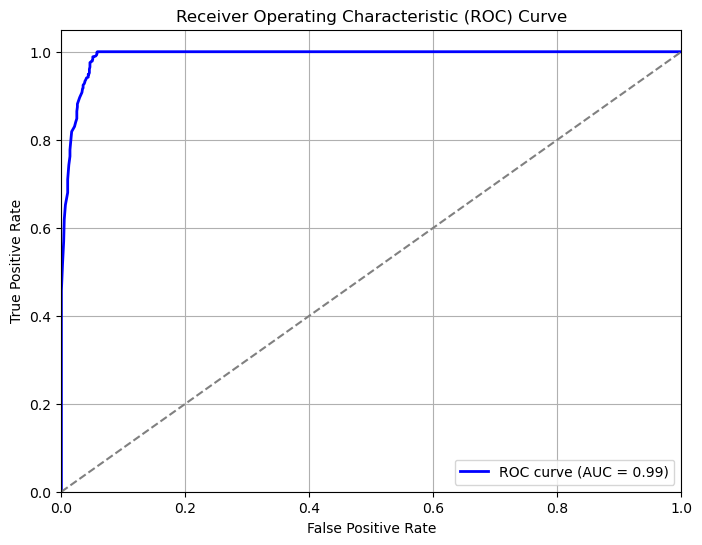

In [66]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
